In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
source('../functions.R')
source('../parameters.sh')
source('parameters.sh')


In [4]:
Sys.glob(file.path(ref_d, 'ontology', paste0('*.', onto_terms))) %>%
lapply(function(f){
    fread(f, col.names=c('term_ID', 'term_desc', 'onto_P', 'onto_lvl'), sep='\t', colClasses = 'character') %>% 
    select(term_ID, term_desc)    
}) %>% bind_rows() %>% unique() -> ontoTerms_df


In [5]:
ontology <- 'GOBiologicalProcess'

file.path(data_d, results_sub_d, rdata_base, 'GREAT', '3_out_by_onto', paste0(ontology, '.tsv.gz')) %>%
fread(colClasses = c('#sample_ID'='character')) %>%
rename('sample_ID'='#sample_ID') %>%
left_join(ontoTerms_df, by='term_ID') -> great_res_df


In [6]:
great_res_df %>% dim()

[1] 84672     9

In [24]:
1:rank %>% lapply(function(component_idx){   
    great_res_df %>% filter(BFold > 2) %>%
    group_by(sample_ID) %>% mutate(BRank = 1:n()) %>% ungroup() %>%
    filter(BRank <= 15) %>%
    filter(sample_ID==component_idx) %>%   
    mutate(
        term_desc=if_else(str_length(term_desc)>38, paste0(str_sub(term_desc, 1, 40), '..'), term_desc)
    ) %>%
    ggplot(aes(x = reorder(term_desc, -BRank), y = -log10(BPval))) +
    geom_col(aes(fill = BFold)) + 
    theme_bw(base_size=11) +
    scale_fill_gradientn(colours = c("skyblue", "blue"))+
    coord_flip() + theme(
        legend.position=c(.92, .2),
        legend.text=element_text(size=7),
        legend.title=element_text(size=7)
    ) +
    labs(
        title=sprintf('Component %s', component_idx), x = '',
        y = '-log10(Binomial p-value)', fill='Binomial\nFold'
    )
}) -> ps_pval


In [25]:
ggsave('great_GO_BP_bar_pval.pdf', do.call("arrangeGrob", c(ps_pval, ncol=2)), width=16, height=20)

In [9]:
great_res_df %>% filter(BFold > 2) %>%
group_by(sample_ID) %>% mutate(BRank = 1:n()) %>% ungroup() %>%
filter(BRank <= 10) %>% select(term_ID) %>% unique() %>% pull() -> great_top_terms


In [10]:
great_res_df %>% filter(term_ID %in% great_top_terms) -> great_res_sub_df


In [11]:
great_res_sub_df %>% dim()

[1] 336   9

In [12]:
great_res_sub_df %>%
mutate(score = -log10(BPval)) %>%
select(sample_ID, term_desc, score) %>%
spread(sample_ID, score, fill=-log10(1)) %>% 
column_to_rownames('term_desc') %>%
as.matrix() -> M


In [26]:
great_res_sub_df %>% 
left_join(
    data.frame(
        term_desc = rownames(M)[(hclust(dist(M)))$order],
        term_desc_hclust_order = 1:nrow(M),
        stringsAsFactors=F
    ),
    by='term_desc'
) %>%
left_join(
    data.frame(
        sample_ID = colnames(M)[(hclust(dist(t(M))))$order],
        sample_ID_hclust_order = 1:ncol(M),
        stringsAsFactors=F
    ),
    by='sample_ID'
) %>%
mutate(
    term_desc=if_else(str_length(term_desc)>38, paste0(str_sub(term_desc, 1, 40), '..'), term_desc)
) %>%
ggplot(aes(reorder(sample_ID, -sample_ID_hclust_order), reorder(term_desc, term_desc_hclust_order), fill=-log10(BPval))) + 
geom_tile() +
theme_bw(base_size=14)+
scale_fill_gradient(low="white", high="blue") +
labs(x = 'Component', y = 'Enriched ontology term') +
theme(legend.position = 'bottom') -> p_great_heatmap_pval
# scale_fill_distiller(palette = "RdPu")

In [27]:
ggsave('great_GO_BP_heatmap_pval.pdf', p_great_heatmap_pval, width=8, height=8)


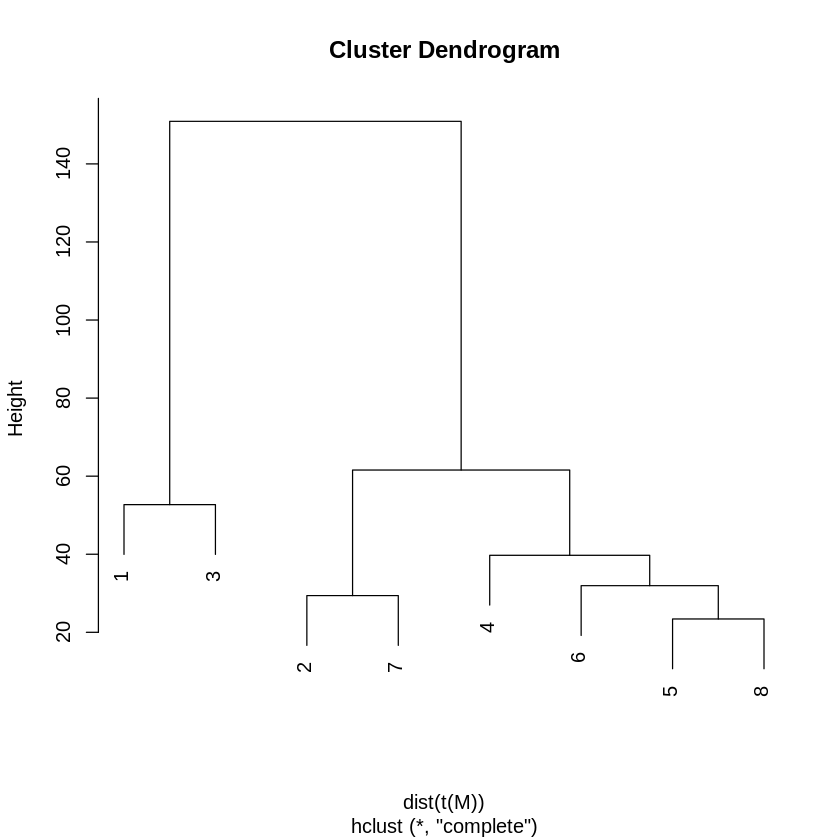

In [28]:
plot(hclust(dist(t(M))))

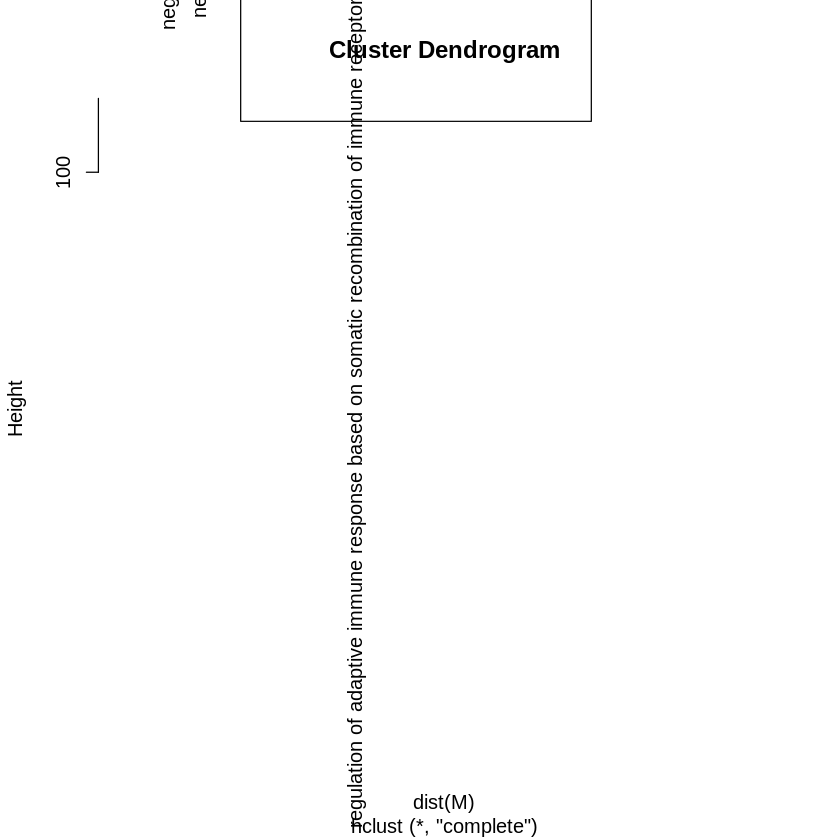

In [29]:
plot(hclust(dist(M)))

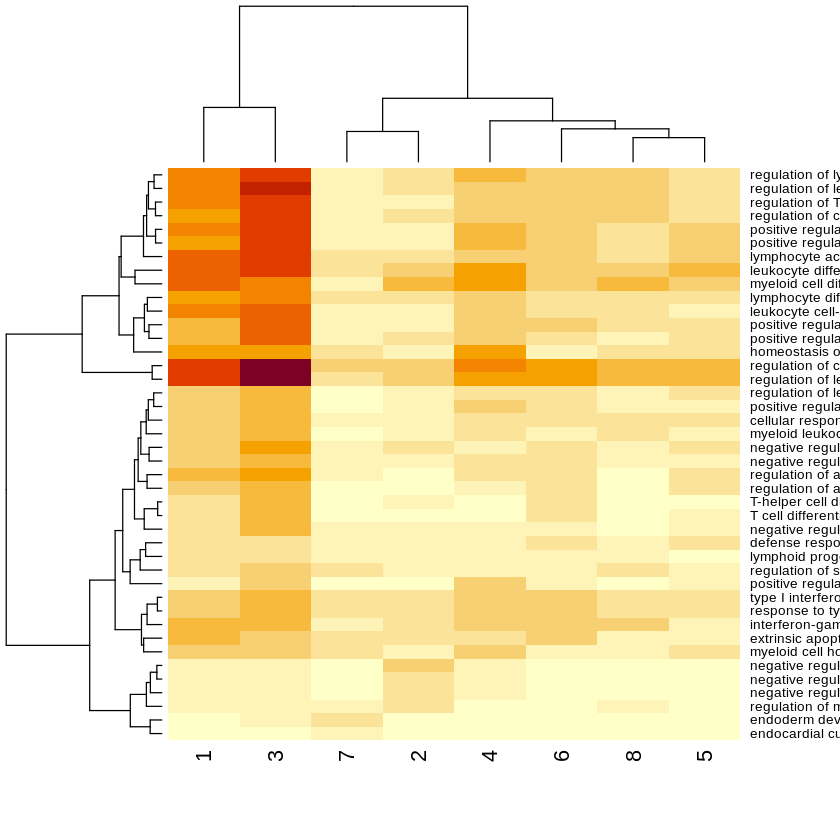

In [30]:
heatmap(M, scale="none")

In [264]:
?heatmap

heatmap {stats},R Documentation
x,numeric matrix of the values to be plotted.
Rowv,"determines if and how the row dendrogram should be computed and reordered. Either a dendrogram or a vector of values used to reorder the row dendrogram or NA to suppress any row dendrogram (and reordering) or by default, NULL, see ‘Details’ below."
Colv,"determines if and how the column dendrogram should be reordered. Has the same options as the Rowv argument above and additionally when x is a square matrix, Colv = ""Rowv"" means that columns should be treated identically to the rows (and so if there is to be no row dendrogram there will not be a column one either)."
distfun,function used to compute the distance (dissimilarity) between both rows and columns. Defaults to dist.
hclustfun,function used to compute the hierarchical clustering when Rowv or Colv are not dendrograms. Defaults to hclust. Should take as argument a result of distfun and return an object to which as.dendrogram can be applied.
reorderfun,"function(d, w) of dendrogram and weights for reordering the row and column dendrograms. The default uses reorder.dendrogram."
add.expr,expression that will be evaluated after the call to image. Can be used to add components to the plot.
symm,logical indicating if x should be treated symmetrically; can only be true when x is a square matrix.
revC,"logical indicating if the column order should be reversed for plotting, such that e.g., for the symmetric case, the symmetry axis is as usual."
scale,"character indicating if the values should be centered and scaled in either the row direction or the column direction, or none. The default is ""row"" if symm false, and ""none"" otherwise."
